# Import Libraries

In [13]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Prepare Data

In [3]:
df = pd.read_csv("../data/processed_data.csv") 
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate RFM Metrics

In [14]:
def calculate_rfm(df, snapshot_date=None):
    if snapshot_date is None:
        snapshot_date = pd.to_datetime(df['TransactionStartTime']).max() + pd.Timedelta(days=1)

    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')
    rfm = df.groupby('CustomerId').agg({
        'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,
        'TransactionId': 'count',
        'Amount': 'sum'
    }).rename(columns={
        'TransactionStartTime': 'Recency',
        'TransactionId': 'Frequency',
        'Amount': 'Monetary'
    }).reset_index()

    return rfm

# assign_risk_label

In [15]:
def assign_risk_label(rfm_df, n_clusters=3, random_state=42):
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

    # Identify the high-risk cluster (lowest engagement)
    cluster_summary = rfm_df.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].mean()
    high_risk_cluster = cluster_summary.sort_values(by=['Frequency', 'Monetary']).index[0]

    rfm_df['is_high_risk'] = (rfm_df['cluster'] == high_risk_cluster).astype(int)
    return rfm_df[['CustomerId', 'is_high_risk']]


# add high risk label to data

In [16]:
def add_high_risk_label_to_data(original_data, rfm_labels):
    return original_data.merge(rfm_labels, on='CustomerId', how='left').fillna({'is_high_risk': 0})

In [8]:
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print("Cluster Summary:\n", cluster_summary)

Cluster Summary:
          Recency  Frequency     Monetary
Cluster                                 
0           61.9        7.7      81723.8
1           29.0     4091.0 -104900000.0
2           12.7       34.8     272654.6


# Visualize Cluster Profiles

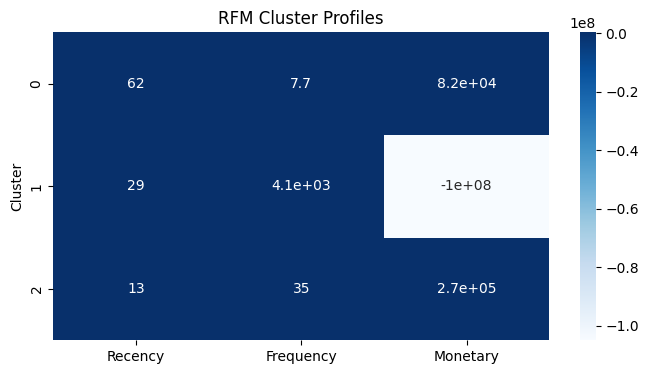

In [9]:
plt.figure(figsize=(8, 4))
sns.heatmap(cluster_summary, annot=True, cmap='Blues')
plt.title("RFM Cluster Profiles")
plt.show()

# Check sample

In [18]:
if __name__ == "__main__":
    df = pd.read_csv("../data/data.csv")
    rfm = calculate_rfm(df)
    rfm_labels = assign_risk_label(rfm)
    merged_df = add_high_risk_label_to_data(df, rfm_labels)
    merged_df.to_csv("../data/labeled_data.csv", index=False)
    print("✅ Labeled dataset saved to ./data/labeled_data.csv")


✅ Labeled dataset saved to ./data/labeled_data.csv
